In [13]:
import pandas as pd
import numpy as np
import text_process as tp

In [14]:
dataset = pd.read_csv(r'../../data/movie/movie_reviews.csv')

In [17]:
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [18]:
reviews = np.array(dataset['review'])
sentiments = np.array(dataset['sentiment'])

In [19]:
train_reviews = reviews[:35000]
train_sentiments = sentiments[:35000]
test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]

In [23]:
norm_train_reviews = tp.normalize_corpus(train_reviews)
norm_test_reviews = tp.normalize_corpus(test_reviews)

In [24]:
norm_train_reviews[3]

'basically family little boy jake think zombie closet amp parent fighting time movie slower soap opera suddenly jake decides become rambo kill zombie ok first going make film must decide thriller drama drama movie watchable parent divorcing amp arguing like real life jake closet totally ruin film expected see boogeyman similar movie instead watched drama meaningless thriller spot 3 10 well playing parent amp descent dialog shot jake ignore'

In [25]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = CountVectorizer(binary=False, min_df=0.0, max_df=1.0, ngram_range=(1,2))
cv_train_features = cv.fit_transform(norm_train_reviews)

In [28]:
norm_train_reviews[0]

'one reviewer ha mentioned watching 1 oz episode hooked right exactly happened first thing struck oz wa brutality unflinching scene violence set right word go trust not show faint hearted timid show pull no punch regard drug sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy not high agenda em city home many aryan muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far away would say main appeal show due fact go show would not dare forget pretty picture painted mainstream audience forget charm forget romance oz doe not mess around first episode ever saw struck nasty wa surreal could not say wa ready watched developed taste oz got accustomed high level graphic violence not violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate turned prison bi

In [30]:
len(cv.vocabulary_)

2315253

In [31]:
cv_train_features.shape

(35000, 2315253)

In [32]:
cv_test_features = cv.transform(norm_test_reviews)

In [33]:
from sklearn.linear_model import SGDClassifier
svm = SGDClassifier(loss='hinge', n_iter=100)

In [34]:
svm.fit(cv_train_features, train_sentiments)
predictions = svm.predict(cv_test_features) 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


In [35]:
from sklearn import metrics
metrics.accuracy_score(test_sentiments, predictions)

0.9030666666666667

In [36]:
predictions

array(['negative', 'positive', 'negative', ..., 'negative', 'negative',
       'negative'], dtype='<U8')

In [37]:
metrics.precision_score(test_sentiments, predictions,average='weighted')

0.9031453718540504

In [38]:
import gensim
import keras
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [39]:
le = LabelEncoder()
num_classes=2 
# tokenize train reviews & encode train labels
tokenized_train = [tp.tokenizer.tokenize(text)
                   for text in norm_train_reviews]

In [42]:
y_tr = le.fit_transform(train_sentiments)
y_train = keras.utils.to_categorical(y_tr, num_classes)

In [43]:
y_train

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [45]:
tokenized_test = [tp.tokenizer.tokenize(text)
                   for text in norm_test_reviews]
y_ts = le.fit_transform(test_sentiments)
y_test = keras.utils.to_categorical(y_ts, num_classes)

In [46]:
w2v_num_features = 500
w2v_model = gensim.models.Word2Vec(tokenized_train, size=w2v_num_features, window=150,
                                   min_count=10, sample=1e-3)

In [47]:
def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.
        
        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [48]:
# generate averaged word vector features from word2vec model
avg_wv_train_features = averaged_word2vec_vectorizer(corpus=tokenized_train, model=w2v_model,
                                                     num_features=500)
avg_wv_test_features = averaged_word2vec_vectorizer(corpus=tokenized_test, model=w2v_model,
                                                    num_features=500)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [50]:
avg_wv_train_features[0]

array([-8.23865978e-02, -2.56891290e-01, -4.08413614e-02, -1.01622465e-01,
       -1.45333194e-01,  1.41242945e-01,  1.13496062e-01, -6.52458304e-02,
       -2.79062914e-02, -2.26074792e-01, -1.90427587e-01, -2.29993588e-01,
        7.76842772e-02,  1.54858975e-01, -3.18691383e-02, -4.32104196e-01,
       -9.43009510e-02, -1.14421689e-01, -5.22531345e-01,  1.84174123e-01,
       -3.43291593e-01, -8.94302937e-02,  2.75814609e-01, -4.80848174e-02,
        7.31600995e-01,  3.19858443e-01, -5.82359175e-02, -1.06094154e-01,
       -1.80186836e-01,  6.78650003e-02,  1.15572567e-01,  2.13282318e-01,
       -1.05449988e-02, -2.64885800e-01,  1.60874079e-01,  2.04880349e-01,
        5.57461260e-02,  1.84952360e-01, -5.49481696e-01, -7.13083032e-02,
       -9.03742909e-02, -2.24219526e-01, -3.01507187e-01,  1.80084304e-02,
        1.87089886e-01, -3.54255562e-02, -1.08821689e-01, -6.48497183e-02,
        1.49339533e-01,  2.20083300e-01, -1.69213017e-01, -2.30688883e-01,
       -8.65283556e-02,  

In [51]:
def construct_deepnn_architecture(num_input_features):
    dnn_model = Sequential()
    dnn_model.add(Dense(512, activation='relu', input_shape=(num_input_features,)))
    dnn_model.add(Dropout(0.2))
    dnn_model.add(Dense(512, activation='relu'))
    dnn_model.add(Dropout(0.2))
    dnn_model.add(Dense(512, activation='relu'))
    dnn_model.add(Dropout(0.2))
    dnn_model.add(Dense(2))
    dnn_model.add(Activation('softmax'))

    dnn_model.compile(loss='categorical_crossentropy', optimizer='adam',                 
                      metrics=['accuracy'])
    return dnn_model

In [52]:
w2v_dnn = construct_deepnn_architecture(num_input_features=500)


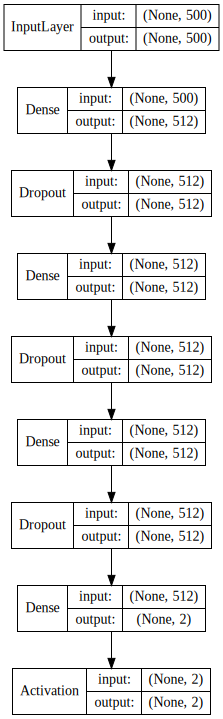

In [53]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(w2v_dnn, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [55]:
batch_size = 100
w2v_dnn.fit(avg_wv_train_features, y_train, epochs=5, batch_size=batch_size, 
            shuffle=True, validation_split=0.1, verbose=1)

Train on 31500 samples, validate on 3500 samples
Epoch 1/5
31500/31500 [==============================] - 12s 370us/step - loss: 0.3051 - acc: 0.8732 - val_loss: 0.3021 - val_acc: 0.8746

In [56]:
y_pred = w2v_dnn.predict_classes(avg_wv_test_features)
predictions = le.inverse_transform(y_pred)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [62]:
from collections import Counter

# build word to index vocabulary
token_counter = Counter([token for review in tokenized_train for token in review])
vocab_map = {item[0]: index+1 for index, item in enumerate(dict(token_counter).items())}
max_index = np.max(list(vocab_map.values()))
vocab_map['PAD_INDEX'] = 0
vocab_map['NOT_FOUND_INDEX'] = max_index+1
vocab_size = len(vocab_map)
# view vocabulary size and part of the vocabulary map
print('Vocabulary Size:', vocab_size)
print('Sample slice of vocabulary map:', dict(list(vocab_map.items())[10:20]))

Vocabulary Size: 108255
Sample slice of vocabulary map: {'artiness': 11, 'kyons': 18, 'megan': 17, 'entreatingly': 19, 'enchanting': 107607, 'sants': 12, '1934earl': 13, 'fightrunner': 14, 'sized': 15, 'tenner': 20}


In [64]:
vocab_map

{'mesmerized': 1,
 'pizazz': 2,
 'inquires': 3,
 'dimensional': 4,
 'endurable': 5,
 'deeperinto': 6,
 'whogivesadamnaboutthesepeople': 7,
 'heartwarmers': 8,
 'walston': 9,
 'dysart': 10,
 'artiness': 11,
 'enchanting': 107607,
 'sants': 12,
 '1934earl': 13,
 'fightrunner': 14,
 'sized': 15,
 'megan': 17,
 'kyons': 18,
 'entreatingly': 19,
 'tenner': 20,
 'boisronds': 21,
 'ericis': 22,
 'tablelike': 23,
 'superannuated': 53054,
 'capanos': 99613,
 'dozing': 26,
 'involvedthis': 27,
 'mumabi': 28,
 'parry': 89378,
 'sumthin': 53056,
 'rebellious': 31,
 'punchy': 33,
 'hazzard': 34,
 'wtfs': 35,
 'curmudgeony': 229,
 'duellist': 37,
 'courtland': 38,
 'apec': 39,
 'obviate': 40,
 'reinitiates': 41,
 'paralellism': 72087,
 'waterson': 42,
 'ironicallyplease': 43,
 'talman': 44,
 'whiskerless': 45,
 'beatthat': 46,
 'nerdsstupid': 47,
 'whaley': 48,
 'saved': 49,
 'handsomelooking': 319,
 'lense': 51,
 'gravelvoiced': 52,
 'darkhumored': 53,
 'bluish': 54,
 'zipped': 44325,
 'clearlystil

In [65]:
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0
max_len = np.max([len(review) for review in tokenized_train])

In [66]:
max_len

1448

In [68]:
from keras.preprocessing import sequence
train_X = [[vocab_map[token] for token in tokenized_review] for tokenized_review in tokenized_train]
train_X = sequence.pad_sequences(train_X, maxlen=max_len)

In [70]:
train_X.shape

(35000, 1448)

In [71]:
train_y = le.fit_transform(train_sentiments)
test_X = [[vocab_map[token] if vocab_map.get(token) else vocab_map['NOT_FOUND_INDEX'] 
           for token in tokenized_review] 
              for tokenized_review in tokenized_test]
test_X = sequence.pad_sequences(test_X, maxlen=max_len)
test_y = le.transform(test_sentiments)

# view vector shapes
print('Max length of train review vectors:', max_len)
print('Train review vectors shape:', train_X.shape, ' Test review vectors shape:', test_X.shape)

Max length of train review vectors: 1448
Train review vectors shape: (35000, 1448)  Test review vectors shape: (15000, 1448)


In [72]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, SpatialDropout1D
from keras.layers import LSTM

EMBEDDING_DIM = 128 # dimension for dense embeddings for each token
LSTM_DIM = 64 # total LSTM units

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [73]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1448, 128)         13856640  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 1448, 128)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 13,906,113
Trainable params: 13,906,113
Non-trainable params: 0
_________________________________________________________________
None
